In [1]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib, collections, itertools, os, re, textwrap, logging
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from functools import reduce

from logging.config import dictConfig
from logging import getLogger


dictConfig(dict(
    version = 1,
    formatters = {
        'f': {'format':
              '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}
        },
    handlers = {
        'h': {'class': 'logging.StreamHandler',
              'formatter': 'f',
              'level': logging.DEBUG}
        },
    root = {
        'handlers': ['h'],
        'level': logging.DEBUG,
        },
))


font = {
#     'family' : 'normal',
#     'weight' : 'bold',
    'size'   : 16
}

matplotlib.rc('font', **font)
logger = getLogger('notebook')

In [ ]:
import pgenlib

In [3]:
ukbb_path = os.path.join(
    '/', 'oak', 'stanford', 'groups', 'mrivas', 'private_data', 'ukbb', '24983', 
)

pgen_path = os.path.join(
    ukbb_path, 'cal', 'pgen'
)

def read_bim_file(chr, app_id = 24983, pgen_path = pgen_path):
    return pd.read_csv(
        os.path.join(pgen_path, 'ukb{}_cal_chr{}_v2.bim'.format(app_id, chr)), sep='\t', 
        names = ['CHR', 'VAR_ID', 'CM', 'POS', 'ALT', 'REF']
    )


## read bim (variant index) file

In [4]:
vars_of_interest = collections.OrderedDict([
    ('GPR151', (5,  145895394)),
    ('PDE3E',  (11, 14865399))
])


In [5]:
bims = {}
for chr, pos in vars_of_interest.values():
    bims[chr] = read_bim_file(chr)
    

In [6]:
def find_index(chr, pos, bims):
    '''Find the index of variant on bim file'''
    return bims[chr]['POS'].tolist().index(pos)


In [7]:
for gene_symbol, variant in vars_of_interest.items():
    chr, pos = variant
    print('{}\t{}\t{}\t{}'.format(gene_symbol, chr, pos, find_index(chr, pos, bims)))

GPR151	5	145895394	35244
PDE3E	11	14865399	6705


## read fam (individual index) file

```
.fam (PLINK sample information file)

Sample information file accompanying a .bed or biallelic .pgen binary genotype table. (--make-just-fam can be used to update just this file.)

A text file with no header line, and one line per sample with the following six fields:

    Family ID ('FID')
    Individual ID ('IID'; cannot be '0')
    Individual ID of father ('0' if father isn't in dataset)
    Individual ID of mother ('0' if mother isn't in dataset)
    Sex code ('1' = male, '2' = female, '0' = unknown)
    Phenotype value ('1' = control, '2' = case, '-9'/'0'/non-numeric = missing data if case/control)

```

In [8]:
fam_df = pd.read_csv(
    os.path.join(pgen_path, 'ukb{}_cal_chr{}_v2.fam'.format(24983, 1)), sep='\t', 
    names = ['FID', 'IID', 'IID_F', 'IID_M', 'SEX', 'PHE'],    
)

## read genotype vector (not allelotype)

In [10]:
def read_geno_by_pos(chr, pos, allele_idx = 1, bims=bims, pgen_path = pgen_path, app_id = 24983):
    var_idx = find_index(chr, pos, bims)
    with pgenlib.PgenReader(
        os.path.join(os.path.join(pgen_path, 'ukb{}_cal_chr{}_v2.pgen'.format(app_id, chr)))
    ) as pgr:
        geno_int_out = np.zeros(pgr.get_raw_sample_ct(), dtype=np.int)
        pgr.read(var_idx, geno_int_out, allele_idx = allele_idx)
    return geno_int_out

In [11]:
geno_vecs = {}
for gene_symbol, variant in vars_of_interest.items():
    chr, pos = variant
    geno_vecs[variant] = read_geno_by_pos(chr, pos, allele_idx=0)
    print('{}\t{}\t{}\t{}'.format(gene_symbol, chr, pos, collections.Counter(geno_vecs[variant])))

GPR151	5	145895394	Counter({0: 480468, 1: 7560, -9: 313, 2: 36})
PDE3E	11	14865399	Counter({0: 486561, 1: 947, -9: 869})


## read covariates

In [12]:
def read_covar():
    covar = pd.read_csv(
        os.path.join(ukbb_path, 'sqc', 'ukb24983_GWAS_covar.phe'), sep='\t'
    )
    return covar[(covar['FID'] > 0) & (covar['IID'] > 0)]    

In [13]:
covar = read_covar()

- fam_file
  - '1' = male
  - '2' = female
  - '0' = unknown (reducted)
- covariates
  - '0' = female
  - '1' = male

## read phenotypes


In [16]:
phes = collections.OrderedDict()


In [32]:
# weight
phes['INI21002'] = pd.read_csv(
    os.path.join(ukbb_path, 'phenotypedata', 'ukb9797_20170818_qt', 'INI21002.phe'), sep='\t',
    names=['FID', 'IID', 'INI21002']
)

# standing height
phes['INI50'] = pd.read_csv(
    os.path.join(ukbb_path, 'phenotypedata', 'ukb9797_20170818_qt', 'INI50.phe'), sep='\t',
    names=['FID', 'IID', 'INI50']
)

# BMI
phes['INI21001'] = pd.read_csv(
    os.path.join(ukbb_path, 'phenotypedata', 'ukb9797_20170818_qt', 'INI21001.phe'), sep='\t',
    names=['FID', 'IID', 'INI21001']
)



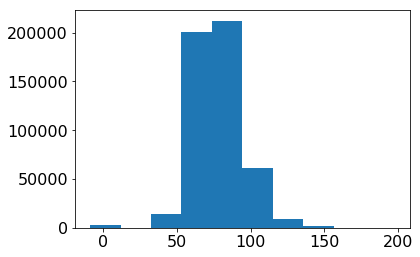

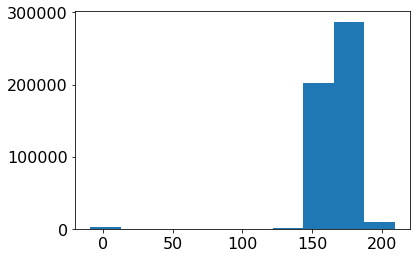

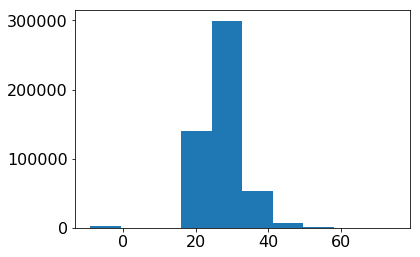

In [34]:
for phe in ['INI21002', 'INI50', 'INI21001']:
    plt.hist(phes[phe][phe])
    plt.show()

## read cohort definitions

In [19]:
cohort = pd.read_csv(
    os.path.join(ukbb_path, 'sqc', 'population_stratification', 'ukb24983_white_british.phe'), sep='\t',
    names=['FID', 'IID']
)


In [20]:
cohort_set = set(zip(cohort['FID'], cohort['IID']))


## join 

In [21]:
geno_df = pd.DataFrame(collections.OrderedDict([
    ('FID', fam_df.FID),
    ('IID', fam_df.IID),
] + [
    (gene_symbol, geno_vecs[variant]) for gene_symbol, variant in vars_of_interest.items()
]
))

In [35]:
df = geno_df.merge(
    phes['INI21002'], how='left', on=['FID', 'IID']
).merge(
    phes['INI50'], how='left', on=['FID', 'IID']
).merge(
    phes['INI21001'], how='left', on=['FID', 'IID']
).merge(
    covar, how='left', on=['FID', 'IID']
)


In [37]:
df['white_british'] = [(fid, iid) in cohort_set for fid, iid in zip(df['FID'], df['IID'])]


In [40]:
df_final = df[(df['FID'] > 0) & (df['IID'] > 0)]


## save to file

In [44]:
df_final.to_csv(
    '../../../private_data/FigS13-15_regression_data.tsv.gz', sep='\t', compression='gzip',
)